In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [3]:
import os
SEQ_LEN = 64
IM_SIZE = 28

In [4]:
def read_img_sequences(path_to_folder, size=500):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * SEQ_LEN
        sequence_labels = [None] * SEQ_LEN
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(IM_SIZE * IM_SIZE).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [5]:
anomaly_data, anomaly_labels = read_img_sequences('data_4_in_7/img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('data_4_in_7/img_ts_normal/')

In [6]:
len(anomaly_data)

500

In [7]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [9]:
device = torch.device('cuda')

In [10]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [11]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [12]:
class CustomLoss(nn.Module):
    
    def __init__(self, alpha=0.5, w=16):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.w = w
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                #w = 16
                #alpha = 0.5
                loss[i] = (self.alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + self.w)], self.w) + 
                           (1 - self.alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [13]:
# input data parameters
input_size = IM_SIZE * IM_SIZE
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [14]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [15]:
device = torch.device("cuda:1")

In [16]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [17]:
def train_model(model, loss_function, epochs=100, print_every=5, LSTM_flag = True):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

## LSTM Model

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        
        return hidden

In [19]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [20]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)

Epoch: 1/60... Step: 5... Loss: -1.713132... Val Loss: -1.951803
Epoch: 2/60... Step: 10... Loss: -2.350043... Val Loss: -2.331757
Epoch: 2/60... Step: 15... Loss: -2.601989... Val Loss: -3.402312
Epoch: 3/60... Step: 20... Loss: -3.273342... Val Loss: -4.876379
Epoch: 3/60... Step: 25... Loss: -8.988995... Val Loss: -6.246268
Epoch: 4/60... Step: 30... Loss: -8.186861... Val Loss: -8.074739
Epoch: 4/60... Step: 35... Loss: -9.104961... Val Loss: -8.572307
Epoch: 5/60... Step: 40... Loss: -9.794010... Val Loss: -8.920572
Epoch: 5/60... Step: 45... Loss: -11.115810... Val Loss: -9.982688
Epoch: 6/60... Step: 50... Loss: -10.851713... Val Loss: -10.759299
Epoch: 7/60... Step: 55... Loss: -11.019271... Val Loss: -11.235148
Epoch: 7/60... Step: 60... Loss: -8.995976... Val Loss: -10.107160
Epoch: 8/60... Step: 65... Loss: -13.789701... Val Loss: -10.621668
Epoch: 8/60... Step: 70... Loss: -13.444029... Val Loss: -11.533076
Epoch: 9/60... Step: 75... Loss: -11.132465... Val Loss: -10.931431

In [21]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [22]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       60, 5, LSTM_flag=True)

Epoch: 1/60... Step: 5... Loss: 0.601782... Val Loss: 0.590719
Epoch: 2/60... Step: 10... Loss: 0.445008... Val Loss: 0.404826
Epoch: 2/60... Step: 15... Loss: 0.316202... Val Loss: 0.311624
Epoch: 3/60... Step: 20... Loss: 0.215332... Val Loss: 0.248975
Epoch: 3/60... Step: 25... Loss: 0.190846... Val Loss: 0.179747
Epoch: 4/60... Step: 30... Loss: 0.122620... Val Loss: 0.123877
Epoch: 4/60... Step: 35... Loss: 0.086201... Val Loss: 0.082894
Epoch: 5/60... Step: 40... Loss: 0.049946... Val Loss: 0.062588
Epoch: 5/60... Step: 45... Loss: 0.047334... Val Loss: 0.056278
Epoch: 6/60... Step: 50... Loss: 0.051752... Val Loss: 0.068186
Epoch: 7/60... Step: 55... Loss: 0.034629... Val Loss: 0.058111
Epoch: 7/60... Step: 60... Loss: 0.043350... Val Loss: 0.063119
Epoch: 8/60... Step: 65... Loss: 0.037182... Val Loss: 0.055171
Epoch: 8/60... Step: 70... Loss: 0.042268... Val Loss: 0.050838
Epoch: 9/60... Step: 75... Loss: 0.030361... Val Loss: 0.049891
Epoch: 9/60... Step: 80... Loss: 0.026534

In [23]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [24]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 30, 5, 
                                    LSTM_flag=True)

Epoch: 1/30... Step: 5... Loss: -1.593004... Val Loss: -1.936965
Epoch: 2/30... Step: 10... Loss: -3.138752... Val Loss: -2.283153
Epoch: 2/30... Step: 15... Loss: -3.223178... Val Loss: -2.815731
Epoch: 3/30... Step: 20... Loss: -3.733777... Val Loss: -4.120877
Epoch: 3/30... Step: 25... Loss: -8.134331... Val Loss: -5.780532
Epoch: 4/30... Step: 30... Loss: -6.904673... Val Loss: -7.287721
Epoch: 4/30... Step: 35... Loss: -7.089154... Val Loss: -8.528045
Epoch: 5/30... Step: 40... Loss: -8.377243... Val Loss: -8.608749
Epoch: 5/30... Step: 45... Loss: -9.936619... Val Loss: -10.344161
Epoch: 6/30... Step: 50... Loss: -10.301812... Val Loss: -10.885713
Epoch: 7/30... Step: 55... Loss: -12.476969... Val Loss: -11.326260
Epoch: 7/30... Step: 60... Loss: -11.520851... Val Loss: -10.830168
Epoch: 8/30... Step: 65... Loss: -11.343795... Val Loss: -11.439355
Epoch: 8/30... Step: 70... Loss: -12.914049... Val Loss: -11.293591
Epoch: 9/30... Step: 75... Loss: -14.809316... Val Loss: -11.73069

In [25]:
model_LSTM_combined, __ = train_model(model_LSTM_combined, first_bce_loss_function, 30, 5, 
                                      LSTM_flag=True)

Epoch: 1/30... Step: 5... Loss: 0.089439... Val Loss: 0.077297
Epoch: 2/30... Step: 10... Loss: 0.039623... Val Loss: 0.056032
Epoch: 2/30... Step: 15... Loss: 0.046298... Val Loss: 0.053958
Epoch: 3/30... Step: 20... Loss: 0.053868... Val Loss: 0.039597
Epoch: 3/30... Step: 25... Loss: 0.034658... Val Loss: 0.042052
Epoch: 4/30... Step: 30... Loss: 0.033162... Val Loss: 0.041043
Epoch: 4/30... Step: 35... Loss: 0.033238... Val Loss: 0.037554
Epoch: 5/30... Step: 40... Loss: 0.040198... Val Loss: 0.033422
Epoch: 5/30... Step: 45... Loss: 0.030056... Val Loss: 0.038062
Epoch: 6/30... Step: 50... Loss: 0.023138... Val Loss: 0.033207
Epoch: 7/30... Step: 55... Loss: 0.030793... Val Loss: 0.033250
Epoch: 7/30... Step: 60... Loss: 0.025157... Val Loss: 0.033776
Epoch: 8/30... Step: 65... Loss: 0.029752... Val Loss: 0.034094
Epoch: 8/30... Step: 70... Loss: 0.016450... Val Loss: 0.035133
Epoch: 9/30... Step: 75... Loss: 0.018893... Val Loss: 0.035483
Epoch: 9/30... Step: 80... Loss: 0.018967

In [26]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [27]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=True):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        if LSTM_flag:
            test_hidden = model.init_hidden(batch_size)
            #test_hidden = tuple([each.data for each in test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [28]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=True):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

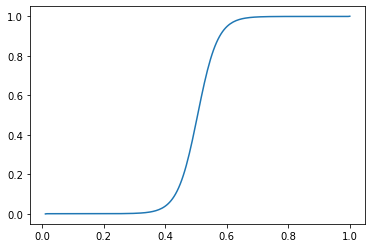

In [29]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]
plt.plot(np.linspace(0.01, 1, threshold_number + 2), threshold_list)

In [30]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [31]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [32]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

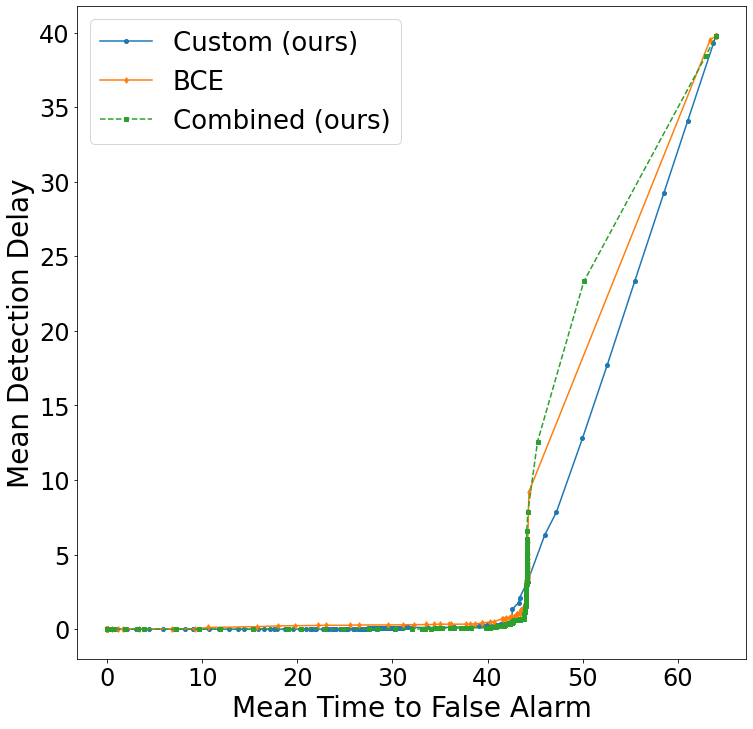

In [33]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('mnist_4_in_7_curve.pdf', bbox_inches='tight')

In [ ]:
def save_metrics_to_file_new_version(model_name, model, test_loader, batch_size,
                                     seq_len, fp_delay, threshold_list, x_coord_arr, path_to_save = ""):
  columns_list = ["Model name", "Mean FP delay", "Mean delay", "Threshold", "TP", "TN", "FP", "FN", "Acc",
                "Precision", "Recall", "F1-score", "G-mean"]
  data_model_results = metrics_by_fp_delay_x_coord(model_name, model, test_loader, batch_size, seq_len,
                                                   fp_delay, threshold_list, x_coord_arr)
  df_main = pd.DataFrame(data_model_results, columns = columns_list)
  df_main.to_excel(os.path.join(path_to_save, model_name + ".xlsx" ), index = False)

In [35]:
%load_ext autoreload
%autoreload 1
%aimport metrics


In [52]:
model_LSTM_custom.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [54]:
metrics.save_metrics_to_file_new_version('Custom', model_LSTM_custom, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_custom, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.99, 45, 50], path_to_save = "")

33.984375 0.33662029495232143 35.078125 0.3710679107501842 35
TP: 12 TN: 29 FP: 23 FN: 0 DELAY: 0.125 FP_DELAY 43.671875
39.5625 0.9564971876670771 43.546875 0.9623558248267451 39.99
TP: 14 TN: 38 FP: 6 FN: 6 DELAY: 5.21875 FP_DELAY 50.515625
43.546875 0.9623558248267451 48.21875 0.9674523120684658 45
TP: 7 TN: 36 FP: 2 FN: 19 DELAY: 10.328125 FP_DELAY 57.28125
48.21875 0.9674523120684658 53.96875 0.9718789695244026 50
TP: 6 TN: 38 FP: 1 FN: 19 DELAY: 10.0625 FP_DELAY 58.578125


In [45]:
metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)

413.57017686631946

In [64]:
model_LSTM_bce.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [65]:
metrics.save_metrics_to_file_new_version('BCE', model_LSTM_bce, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_bce, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.9, 45, 50], path_to_save = "")

34.328125 0.02812103047559733 35.375 0.03254768793153412 35
TP: 12 TN: 35 FP: 17 FN: 0 DELAY: 0.265625 FP_DELAY 43.5
38.421875 0.9999401505276208 57.96875 0.9999485254648226 39.9
TP: 27 TN: 35 FP: 1 FN: 1 DELAY: 5.890625 FP_DELAY 47.953125
38.421875 0.9999401505276208 57.96875 0.9999485254648226 45
TP: 22 TN: 34 FP: 1 FN: 7 DELAY: 9.84375 FP_DELAY 50.796875
38.421875 0.9999401505276208 57.96875 0.9999485254648226 50
TP: 16 TN: 33 FP: 1 FN: 14 DELAY: 13.75 FP_DELAY 55.203125


In [66]:
metrics.area_under_graph(delay_list_LSTM_bce, fp_delay_list_LSTM_bce)

788.3809070121953

In [68]:
metrics.save_metrics_to_file_new_version('Cobined', model_LSTM_combined, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_combined, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 40, 45, 50], path_to_save = "")

34.984375 0.01807518260025041 35.125 0.020954573680812282 35
TP: 8 TN: 35 FP: 21 FN: 0 DELAY: 0.03125 FP_DELAY 46.4375
38.71875 0.9998521398034467 58.515625 0.9998728288098837 40
TP: 26 TN: 37 FP: 0 FN: 1 DELAY: 6.375 FP_DELAY 47.84375
38.71875 0.9998521398034467 58.515625 0.9998728288098837 45
TP: 19 TN: 34 FP: 0 FN: 11 DELAY: 11.359375 FP_DELAY 52.953125
38.71875 0.9998521398034467 58.515625 0.9998728288098837 50
TP: 9 TN: 40 FP: 0 FN: 15 DELAY: 12.015625 FP_DELAY 58.875


In [69]:
metrics.area_under_graph(delay_list_LSTM_combined, fp_delay_list_LSTM_combined)

786.539824695122

In [60]:
model_LSTM_combined.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [62]:
metrics.save_metrics_to_file_new_version('Combined', model_LSTM_bce, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_custom, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.99, 45, 50], path_to_save = "")

33.984375 0.33662029495232143 35.078125 0.3710679107501842 35
TP: 18 TN: 36 FP: 10 FN: 0 DELAY: 0.4375 FP_DELAY 46.375
39.5625 0.9564971876670771 43.546875 0.9623558248267451 39.99
TP: 22 TN: 33 FP: 9 FN: 0 DELAY: 0.609375 FP_DELAY 44.703125
43.546875 0.9623558248267451 48.21875 0.9674523120684658 45
TP: 20 TN: 36 FP: 8 FN: 0 DELAY: 0.59375 FP_DELAY 47.453125
48.21875 0.9674523120684658 53.96875 0.9718789695244026 50
TP: 17 TN: 39 FP: 8 FN: 0 DELAY: 0.28125 FP_DELAY 48.609375


# WS

In [36]:
from tqdm import tqdm

res_metrics = []
res_auc = []
for i in range(10):

    ws = [1, 2, 3, 4, 5, 6, 7, 8, 16, 24, 32, 40, 48, 56, 64]
    w_dict_metrics = {}
    w_dict_auc = {}


    for w in tqdm(ws):

        model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
        loss_function = CustomLoss(w=w)
        model_LSTM_custom.to(device)

        model_LSTM_custom, (loss_list, acc_list, 
                            overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 100, LSTM_flag=True)


        test_batch_size = 64
        final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

        (fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
         delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                               threshold_list, LSTM_flag=True)

        w_dict_metrics[w] = (fp_delay_list_LSTM_custom, delay_list_LSTM_custom)

        w_dict_auc[w] = metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)
    res_metrics.append(w_dict_metrics)
    res_auc.append(w_dict_auc)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -8.948978... Val Loss: -8.601395
Epoch: 23/60... Step: 200... Loss: -9.340742... Val Loss: -11.946132
Epoch: 34/60... Step: 300... Loss: -10.459198... Val Loss: -12.034127
Epoch: 45/60... Step: 400... Loss: -14.426385... Val Loss: -12.225543
Epoch: 56/60... Step: 500... Loss: -12.491844... Val Loss: -11.603811


  7%|▋         | 1/15 [03:59<55:51, 239.38s/it]

Epoch: 12/60... Step: 100... Loss: -9.864717... Val Loss: -9.795673
Epoch: 23/60... Step: 200... Loss: -14.566732... Val Loss: -10.613674
Epoch: 34/60... Step: 300... Loss: -8.424088... Val Loss: -10.714851
Epoch: 45/60... Step: 400... Loss: -11.433832... Val Loss: -10.913294
Epoch: 56/60... Step: 500... Loss: -13.631280... Val Loss: -13.638002


 13%|█▎        | 2/15 [08:02<52:05, 240.41s/it]

Epoch: 12/60... Step: 100... Loss: -11.296511... Val Loss: -12.082672
Epoch: 23/60... Step: 200... Loss: -15.592840... Val Loss: -13.010384
Epoch: 34/60... Step: 300... Loss: -13.359602... Val Loss: -11.988082
Epoch: 45/60... Step: 400... Loss: -13.668680... Val Loss: -9.383632
Epoch: 56/60... Step: 500... Loss: -13.717839... Val Loss: -13.227301


 20%|██        | 3/15 [12:08<48:26, 242.21s/it]

Epoch: 12/60... Step: 100... Loss: -14.665328... Val Loss: -12.371352
Epoch: 23/60... Step: 200... Loss: -13.792182... Val Loss: -12.553322
Epoch: 34/60... Step: 300... Loss: -12.123559... Val Loss: -13.471211
Epoch: 45/60... Step: 400... Loss: -15.718581... Val Loss: -12.810280
Epoch: 56/60... Step: 500... Loss: -14.226028... Val Loss: -13.647045


 27%|██▋       | 4/15 [16:12<44:31, 242.84s/it]

Epoch: 12/60... Step: 100... Loss: -13.384299... Val Loss: -11.959116
Epoch: 23/60... Step: 200... Loss: -8.418479... Val Loss: -12.568864
Epoch: 34/60... Step: 300... Loss: -12.732450... Val Loss: -14.517457
Epoch: 45/60... Step: 400... Loss: -11.700607... Val Loss: -13.210920
Epoch: 56/60... Step: 500... Loss: -11.550230... Val Loss: -11.236339


 33%|███▎      | 5/15 [20:17<40:33, 243.39s/it]

Epoch: 12/60... Step: 100... Loss: -13.614651... Val Loss: -10.382387
Epoch: 23/60... Step: 200... Loss: -15.195056... Val Loss: -13.641518
Epoch: 34/60... Step: 300... Loss: -12.243919... Val Loss: -13.446699
Epoch: 45/60... Step: 400... Loss: -12.288088... Val Loss: -13.886528
Epoch: 56/60... Step: 500... Loss: -10.217720... Val Loss: -14.263110


 40%|████      | 6/15 [24:22<36:34, 243.86s/it]

Epoch: 12/60... Step: 100... Loss: -11.771634... Val Loss: -9.239702
Epoch: 23/60... Step: 200... Loss: -14.358560... Val Loss: -11.904220
Epoch: 34/60... Step: 300... Loss: -15.476042... Val Loss: -13.165354
Epoch: 45/60... Step: 400... Loss: -12.203472... Val Loss: -12.696588
Epoch: 56/60... Step: 500... Loss: -14.662278... Val Loss: -12.214562


 47%|████▋     | 7/15 [28:26<32:29, 243.75s/it]

Epoch: 12/60... Step: 100... Loss: -13.489098... Val Loss: -9.227231
Epoch: 23/60... Step: 200... Loss: -15.383813... Val Loss: -12.386928
Epoch: 34/60... Step: 300... Loss: -15.305426... Val Loss: -11.960211
Epoch: 45/60... Step: 400... Loss: -14.471086... Val Loss: -13.004426
Epoch: 56/60... Step: 500... Loss: -14.345957... Val Loss: -12.616074


 53%|█████▎    | 8/15 [32:29<28:25, 243.59s/it]

Epoch: 12/60... Step: 100... Loss: -10.954101... Val Loss: -9.928782
Epoch: 23/60... Step: 200... Loss: -18.147247... Val Loss: -12.557571
Epoch: 34/60... Step: 300... Loss: -12.430506... Val Loss: -13.267557
Epoch: 45/60... Step: 400... Loss: -12.537983... Val Loss: -13.045535
Epoch: 56/60... Step: 500... Loss: -14.376808... Val Loss: -13.171333


 60%|██████    | 9/15 [36:33<24:23, 243.85s/it]

Epoch: 12/60... Step: 100... Loss: -10.640850... Val Loss: -10.638517
Epoch: 23/60... Step: 200... Loss: -12.024364... Val Loss: -12.225169
Epoch: 34/60... Step: 300... Loss: -12.239944... Val Loss: -12.569654
Epoch: 45/60... Step: 400... Loss: -15.931326... Val Loss: -14.714356
Epoch: 56/60... Step: 500... Loss: -14.670912... Val Loss: -13.861183


 67%|██████▋   | 10/15 [40:36<20:18, 243.66s/it]

Epoch: 12/60... Step: 100... Loss: -13.109787... Val Loss: -12.858098
Epoch: 23/60... Step: 200... Loss: -15.597935... Val Loss: -12.335037
Epoch: 34/60... Step: 300... Loss: -12.665998... Val Loss: -11.127727
Epoch: 45/60... Step: 400... Loss: -13.114093... Val Loss: -13.787942
Epoch: 56/60... Step: 500... Loss: -16.954880... Val Loss: -13.512111


 73%|███████▎  | 11/15 [44:41<16:15, 243.81s/it]

Epoch: 12/60... Step: 100... Loss: -12.445431... Val Loss: -10.887706
Epoch: 23/60... Step: 200... Loss: -14.601403... Val Loss: -14.206320
Epoch: 34/60... Step: 300... Loss: -15.039373... Val Loss: -13.328572
Epoch: 45/60... Step: 400... Loss: -12.471601... Val Loss: -13.090009
Epoch: 56/60... Step: 500... Loss: -12.581079... Val Loss: -12.744399


 80%|████████  | 12/15 [48:43<12:10, 243.44s/it]

Epoch: 12/60... Step: 100... Loss: -11.368265... Val Loss: -11.488917
Epoch: 23/60... Step: 200... Loss: -13.362464... Val Loss: -12.557592
Epoch: 34/60... Step: 300... Loss: -13.042405... Val Loss: -13.383077
Epoch: 45/60... Step: 400... Loss: -17.067913... Val Loss: -13.078645
Epoch: 56/60... Step: 500... Loss: -12.563967... Val Loss: -12.487782


 87%|████████▋ | 13/15 [52:48<08:07, 243.84s/it]

Epoch: 12/60... Step: 100... Loss: -12.897570... Val Loss: -12.052753
Epoch: 23/60... Step: 200... Loss: -15.078045... Val Loss: -11.283426
Epoch: 34/60... Step: 300... Loss: -15.626652... Val Loss: -14.122050
Epoch: 45/60... Step: 400... Loss: -13.301155... Val Loss: -12.543110
Epoch: 56/60... Step: 500... Loss: -16.875792... Val Loss: -13.199882


 93%|█████████▎| 14/15 [56:52<04:03, 243.97s/it]

Epoch: 12/60... Step: 100... Loss: -13.489299... Val Loss: -11.903603
Epoch: 23/60... Step: 200... Loss: -14.031211... Val Loss: -13.162143
Epoch: 34/60... Step: 300... Loss: -15.830294... Val Loss: -12.603625
Epoch: 45/60... Step: 400... Loss: -14.510186... Val Loss: -12.910515
Epoch: 56/60... Step: 500... Loss: -15.455423... Val Loss: -11.238977


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -11.384807... Val Loss: -11.270377
Epoch: 23/60... Step: 200... Loss: -12.553626... Val Loss: -11.959834
Epoch: 34/60... Step: 300... Loss: -11.937970... Val Loss: -11.377823
Epoch: 45/60... Step: 400... Loss: -9.946217... Val Loss: -13.055047
Epoch: 56/60... Step: 500... Loss: -10.063967... Val Loss: -12.070435


  7%|▋         | 1/15 [03:59<55:48, 239.15s/it]

Epoch: 12/60... Step: 100... Loss: -11.645815... Val Loss: -6.881990
Epoch: 23/60... Step: 200... Loss: -11.955068... Val Loss: -10.696702
Epoch: 34/60... Step: 300... Loss: -12.466463... Val Loss: -10.475664
Epoch: 45/60... Step: 400... Loss: -14.542805... Val Loss: -13.228453
Epoch: 56/60... Step: 500... Loss: -17.640322... Val Loss: -12.812856


 13%|█▎        | 2/15 [08:02<52:06, 240.53s/it]

Epoch: 12/60... Step: 100... Loss: -12.020378... Val Loss: -12.071752
Epoch: 23/60... Step: 200... Loss: -16.392160... Val Loss: -13.960135
Epoch: 34/60... Step: 300... Loss: -15.752021... Val Loss: -10.715867
Epoch: 45/60... Step: 400... Loss: -15.615854... Val Loss: -12.016086
Epoch: 56/60... Step: 500... Loss: -15.264795... Val Loss: -12.363302


 20%|██        | 3/15 [12:06<48:18, 241.58s/it]

Epoch: 12/60... Step: 100... Loss: -14.326829... Val Loss: -12.097743
Epoch: 23/60... Step: 200... Loss: -13.864783... Val Loss: -10.552566
Epoch: 34/60... Step: 300... Loss: -15.561183... Val Loss: -12.980816
Epoch: 45/60... Step: 400... Loss: -14.459592... Val Loss: -13.285918
Epoch: 56/60... Step: 500... Loss: -14.694421... Val Loss: -14.239839


 27%|██▋       | 4/15 [16:12<44:31, 242.82s/it]

Epoch: 12/60... Step: 100... Loss: -11.624811... Val Loss: -11.513238
Epoch: 23/60... Step: 200... Loss: -12.491478... Val Loss: -13.997151
Epoch: 34/60... Step: 300... Loss: -12.968958... Val Loss: -12.562332
Epoch: 45/60... Step: 400... Loss: -13.931135... Val Loss: -13.992906
Epoch: 56/60... Step: 500... Loss: -13.805833... Val Loss: -12.608912


 33%|███▎      | 5/15 [20:15<40:28, 242.89s/it]

Epoch: 12/60... Step: 100... Loss: -13.304514... Val Loss: -12.590885
Epoch: 23/60... Step: 200... Loss: -13.682175... Val Loss: -13.679969
Epoch: 34/60... Step: 300... Loss: -13.425087... Val Loss: -13.157621
Epoch: 45/60... Step: 400... Loss: -18.349659... Val Loss: -13.151525
Epoch: 56/60... Step: 500... Loss: -15.019869... Val Loss: -13.928588


 40%|████      | 6/15 [24:18<36:26, 242.89s/it]

Epoch: 12/60... Step: 100... Loss: -13.522261... Val Loss: -11.991139
Epoch: 23/60... Step: 200... Loss: -16.631767... Val Loss: -12.554167
Epoch: 34/60... Step: 300... Loss: -14.589244... Val Loss: -13.550678
Epoch: 45/60... Step: 400... Loss: -13.488253... Val Loss: -13.476419
Epoch: 56/60... Step: 500... Loss: -18.173477... Val Loss: -12.877063


 47%|████▋     | 7/15 [28:22<32:25, 243.13s/it]

Epoch: 12/60... Step: 100... Loss: -12.946121... Val Loss: -11.723581
Epoch: 23/60... Step: 200... Loss: -14.316587... Val Loss: -12.861559
Epoch: 34/60... Step: 300... Loss: -14.021233... Val Loss: -13.472213
Epoch: 45/60... Step: 400... Loss: -18.814041... Val Loss: -12.995087
Epoch: 56/60... Step: 500... Loss: -10.696806... Val Loss: -13.248480


 53%|█████▎    | 8/15 [32:26<28:23, 243.33s/it]

Epoch: 12/60... Step: 100... Loss: -12.261792... Val Loss: -12.410938
Epoch: 23/60... Step: 200... Loss: -11.828991... Val Loss: -10.647768
Epoch: 34/60... Step: 300... Loss: -13.723070... Val Loss: -13.732536
Epoch: 45/60... Step: 400... Loss: -13.202987... Val Loss: -11.959232
Epoch: 56/60... Step: 500... Loss: -13.087718... Val Loss: -13.891539


 60%|██████    | 9/15 [36:29<24:20, 243.49s/it]

Epoch: 12/60... Step: 100... Loss: -11.502112... Val Loss: -11.545801
Epoch: 23/60... Step: 200... Loss: -16.696007... Val Loss: -13.559607
Epoch: 34/60... Step: 300... Loss: -14.018219... Val Loss: -14.016663
Epoch: 45/60... Step: 400... Loss: -13.559046... Val Loss: -13.609685
Epoch: 56/60... Step: 500... Loss: -15.048725... Val Loss: -13.351137


 67%|██████▋   | 10/15 [40:35<20:19, 243.99s/it]

Epoch: 12/60... Step: 100... Loss: -10.699730... Val Loss: -11.286390
Epoch: 23/60... Step: 200... Loss: -13.237733... Val Loss: -13.051076
Epoch: 34/60... Step: 300... Loss: -16.758741... Val Loss: -11.511866
Epoch: 45/60... Step: 400... Loss: -15.778633... Val Loss: -12.498708
Epoch: 56/60... Step: 500... Loss: -17.451345... Val Loss: -13.594889


 73%|███████▎  | 11/15 [44:39<16:16, 244.18s/it]

Epoch: 12/60... Step: 100... Loss: -12.203796... Val Loss: -11.495961
Epoch: 23/60... Step: 200... Loss: -14.168449... Val Loss: -13.683049
Epoch: 34/60... Step: 300... Loss: -13.931759... Val Loss: -13.581287
Epoch: 45/60... Step: 400... Loss: -13.527271... Val Loss: -13.196867
Epoch: 56/60... Step: 500... Loss: -14.762053... Val Loss: -12.438164


 80%|████████  | 12/15 [48:43<12:12, 244.15s/it]

Epoch: 12/60... Step: 100... Loss: -12.721655... Val Loss: -11.324328
Epoch: 23/60... Step: 200... Loss: -12.940332... Val Loss: -11.131941
Epoch: 34/60... Step: 300... Loss: -15.208337... Val Loss: -13.430802
Epoch: 45/60... Step: 400... Loss: -13.506083... Val Loss: -11.568095
Epoch: 56/60... Step: 500... Loss: -13.994224... Val Loss: -12.913323


 87%|████████▋ | 13/15 [52:48<08:08, 244.20s/it]

Epoch: 12/60... Step: 100... Loss: -10.303383... Val Loss: -10.816291
Epoch: 23/60... Step: 200... Loss: -15.172958... Val Loss: -11.290993
Epoch: 34/60... Step: 300... Loss: -11.358223... Val Loss: -12.187744
Epoch: 45/60... Step: 400... Loss: -14.275780... Val Loss: -14.454922
Epoch: 56/60... Step: 500... Loss: -12.229491... Val Loss: -13.601590


 93%|█████████▎| 14/15 [56:52<04:04, 244.32s/it]

Epoch: 12/60... Step: 100... Loss: -9.836115... Val Loss: -8.802463
Epoch: 23/60... Step: 200... Loss: -16.977694... Val Loss: -12.469031
Epoch: 34/60... Step: 300... Loss: -17.188120... Val Loss: -12.903242
Epoch: 45/60... Step: 400... Loss: -13.481636... Val Loss: -14.140267
Epoch: 56/60... Step: 500... Loss: -16.132147... Val Loss: -13.653173


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -9.753017... Val Loss: -10.198625
Epoch: 23/60... Step: 200... Loss: -12.855322... Val Loss: -11.486529
Epoch: 34/60... Step: 300... Loss: -13.142097... Val Loss: -11.102930
Epoch: 45/60... Step: 400... Loss: -12.837410... Val Loss: -11.366426
Epoch: 56/60... Step: 500... Loss: -9.868216... Val Loss: -11.841954


  7%|▋         | 1/15 [03:58<55:45, 238.98s/it]

Epoch: 12/60... Step: 100... Loss: -13.368598... Val Loss: -8.910834
Epoch: 23/60... Step: 200... Loss: -10.614693... Val Loss: -10.619092
Epoch: 34/60... Step: 300... Loss: -15.262668... Val Loss: -11.013970
Epoch: 45/60... Step: 400... Loss: -11.562714... Val Loss: -11.521815
Epoch: 56/60... Step: 500... Loss: -15.106762... Val Loss: -13.935693


 13%|█▎        | 2/15 [08:03<52:07, 240.55s/it]

Epoch: 12/60... Step: 100... Loss: -12.065300... Val Loss: -10.866954
Epoch: 23/60... Step: 200... Loss: -14.611392... Val Loss: -14.556189
Epoch: 34/60... Step: 300... Loss: -11.814100... Val Loss: -11.029662
Epoch: 45/60... Step: 400... Loss: -15.435675... Val Loss: -13.322780
Epoch: 56/60... Step: 500... Loss: -11.675213... Val Loss: -13.391334


 20%|██        | 3/15 [12:06<48:17, 241.48s/it]

Epoch: 12/60... Step: 100... Loss: -10.935408... Val Loss: -10.695062
Epoch: 23/60... Step: 200... Loss: -15.700084... Val Loss: -12.629814
Epoch: 34/60... Step: 300... Loss: -12.980358... Val Loss: -13.127905
Epoch: 45/60... Step: 400... Loss: -13.971296... Val Loss: -14.031154
Epoch: 56/60... Step: 500... Loss: -12.293509... Val Loss: -12.993087


 27%|██▋       | 4/15 [16:11<44:27, 242.51s/it]

Epoch: 12/60... Step: 100... Loss: -11.974909... Val Loss: -13.427069
Epoch: 23/60... Step: 200... Loss: -9.839521... Val Loss: -12.544465
Epoch: 34/60... Step: 300... Loss: -14.795534... Val Loss: -14.016587
Epoch: 45/60... Step: 400... Loss: -16.013031... Val Loss: -12.888749
Epoch: 56/60... Step: 500... Loss: -14.126024... Val Loss: -13.292324


 33%|███▎      | 5/15 [20:16<40:31, 243.11s/it]

Epoch: 12/60... Step: 100... Loss: -12.593742... Val Loss: -12.780683
Epoch: 23/60... Step: 200... Loss: -12.571910... Val Loss: -12.357738
Epoch: 34/60... Step: 300... Loss: -12.634810... Val Loss: -14.030786
Epoch: 45/60... Step: 400... Loss: -16.580952... Val Loss: -11.482735
Epoch: 56/60... Step: 500... Loss: -15.019014... Val Loss: -13.529502


 40%|████      | 6/15 [24:22<36:36, 244.03s/it]

Epoch: 12/60... Step: 100... Loss: -13.956690... Val Loss: -11.953791
Epoch: 23/60... Step: 200... Loss: -11.917152... Val Loss: -12.843542
Epoch: 34/60... Step: 300... Loss: -12.423900... Val Loss: -13.213718
Epoch: 45/60... Step: 400... Loss: -14.422899... Val Loss: -13.376525
Epoch: 56/60... Step: 500... Loss: -12.718472... Val Loss: -15.222871


 47%|████▋     | 7/15 [28:27<32:34, 244.33s/it]

Epoch: 12/60... Step: 100... Loss: -14.980685... Val Loss: -11.661838
Epoch: 23/60... Step: 200... Loss: -15.441147... Val Loss: -12.732698
Epoch: 34/60... Step: 300... Loss: -13.411583... Val Loss: -14.276759
Epoch: 45/60... Step: 400... Loss: -13.368532... Val Loss: -13.677640
Epoch: 56/60... Step: 500... Loss: -14.503392... Val Loss: -14.315589


 53%|█████▎    | 8/15 [32:31<28:30, 244.32s/it]

Epoch: 12/60... Step: 100... Loss: -11.833346... Val Loss: -8.293533
Epoch: 23/60... Step: 200... Loss: -14.938332... Val Loss: -12.314206
Epoch: 34/60... Step: 300... Loss: -14.379306... Val Loss: -13.726830
Epoch: 45/60... Step: 400... Loss: -16.739105... Val Loss: -13.546953
Epoch: 56/60... Step: 500... Loss: -14.873820... Val Loss: -13.475166


 60%|██████    | 9/15 [36:36<24:26, 244.44s/it]

Epoch: 12/60... Step: 100... Loss: -12.541017... Val Loss: -12.695249
Epoch: 23/60... Step: 200... Loss: -15.735030... Val Loss: -12.529877
Epoch: 34/60... Step: 300... Loss: -15.363775... Val Loss: -13.196627
Epoch: 45/60... Step: 400... Loss: -18.166197... Val Loss: -12.090133
Epoch: 56/60... Step: 500... Loss: -12.782126... Val Loss: -12.238105


 67%|██████▋   | 10/15 [40:41<20:22, 244.54s/it]

Epoch: 12/60... Step: 100... Loss: -12.420089... Val Loss: -11.406117
Epoch: 23/60... Step: 200... Loss: -13.230915... Val Loss: -12.992170
Epoch: 34/60... Step: 300... Loss: -13.957294... Val Loss: -13.566916
Epoch: 45/60... Step: 400... Loss: -14.528208... Val Loss: -12.318602
Epoch: 56/60... Step: 500... Loss: -16.033281... Val Loss: -13.820770


 73%|███████▎  | 11/15 [44:47<16:19, 244.90s/it]

Epoch: 12/60... Step: 100... Loss: -10.880275... Val Loss: -11.334665
Epoch: 23/60... Step: 200... Loss: -15.508224... Val Loss: -13.684572
Epoch: 34/60... Step: 300... Loss: -15.685632... Val Loss: -12.707541
Epoch: 45/60... Step: 400... Loss: -13.321795... Val Loss: -13.774553
Epoch: 56/60... Step: 500... Loss: -15.447512... Val Loss: -13.259296


 80%|████████  | 12/15 [48:51<12:14, 244.86s/it]

Epoch: 12/60... Step: 100... Loss: -15.420208... Val Loss: -12.873896
Epoch: 23/60... Step: 200... Loss: -16.622463... Val Loss: -13.069550
Epoch: 34/60... Step: 300... Loss: -13.862338... Val Loss: -12.453298
Epoch: 45/60... Step: 400... Loss: -11.618202... Val Loss: -12.952097
Epoch: 56/60... Step: 500... Loss: -13.733736... Val Loss: -13.115707


 87%|████████▋ | 13/15 [52:57<08:10, 245.18s/it]

Epoch: 12/60... Step: 100... Loss: -11.794987... Val Loss: -12.030814
Epoch: 23/60... Step: 200... Loss: -11.285711... Val Loss: -12.185666
Epoch: 34/60... Step: 300... Loss: -16.212490... Val Loss: -14.349091
Epoch: 45/60... Step: 400... Loss: -13.058458... Val Loss: -12.344858
Epoch: 56/60... Step: 500... Loss: -15.498137... Val Loss: -13.366693


 93%|█████████▎| 14/15 [57:02<04:04, 244.98s/it]

Epoch: 12/60... Step: 100... Loss: -10.744276... Val Loss: -11.930373
Epoch: 23/60... Step: 200... Loss: -14.598095... Val Loss: -12.278383
Epoch: 34/60... Step: 300... Loss: -13.867049... Val Loss: -12.872068
Epoch: 45/60... Step: 400... Loss: -14.526479... Val Loss: -13.196288
Epoch: 56/60... Step: 500... Loss: -13.281877... Val Loss: -13.530897


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -11.371119... Val Loss: -9.673228
Epoch: 23/60... Step: 200... Loss: -10.187654... Val Loss: -11.290424
Epoch: 34/60... Step: 300... Loss: -15.661637... Val Loss: -11.043447
Epoch: 45/60... Step: 400... Loss: -11.244117... Val Loss: -11.171980
Epoch: 56/60... Step: 500... Loss: -13.464149... Val Loss: -11.582353


  7%|▋         | 1/15 [03:59<55:53, 239.56s/it]

Epoch: 12/60... Step: 100... Loss: -10.386869... Val Loss: -10.016012
Epoch: 23/60... Step: 200... Loss: -12.147757... Val Loss: -10.788822
Epoch: 34/60... Step: 300... Loss: -15.853878... Val Loss: -10.658319
Epoch: 45/60... Step: 400... Loss: -16.348652... Val Loss: -11.144798
Epoch: 56/60... Step: 500... Loss: -13.011618... Val Loss: -11.934647


 13%|█▎        | 2/15 [08:04<52:14, 241.15s/it]

Epoch: 12/60... Step: 100... Loss: -13.928693... Val Loss: -9.165833
Epoch: 23/60... Step: 200... Loss: -13.099836... Val Loss: -13.586654
Epoch: 34/60... Step: 300... Loss: -10.240768... Val Loss: -11.586562
Epoch: 45/60... Step: 400... Loss: -13.804337... Val Loss: -12.707394
Epoch: 56/60... Step: 500... Loss: -17.017178... Val Loss: -13.425674


 20%|██        | 3/15 [12:09<48:27, 242.32s/it]

Epoch: 12/60... Step: 100... Loss: -10.079797... Val Loss: -9.933022
Epoch: 23/60... Step: 200... Loss: -12.319710... Val Loss: -13.294278
Epoch: 34/60... Step: 300... Loss: -14.711704... Val Loss: -13.854577
Epoch: 45/60... Step: 400... Loss: -10.737710... Val Loss: -13.430621
Epoch: 56/60... Step: 500... Loss: -14.051740... Val Loss: -13.203425


 27%|██▋       | 4/15 [16:13<44:31, 242.87s/it]

Epoch: 12/60... Step: 100... Loss: -11.604895... Val Loss: -11.603451
Epoch: 23/60... Step: 200... Loss: -10.643671... Val Loss: -9.899607
Epoch: 34/60... Step: 300... Loss: -16.734831... Val Loss: -11.976484
Epoch: 45/60... Step: 400... Loss: -13.823757... Val Loss: -12.966817
Epoch: 56/60... Step: 500... Loss: -13.923939... Val Loss: -14.286659


 33%|███▎      | 5/15 [20:18<40:33, 243.34s/it]

Epoch: 12/60... Step: 100... Loss: -10.824941... Val Loss: -11.504903
Epoch: 23/60... Step: 200... Loss: -13.953536... Val Loss: -12.174661
Epoch: 34/60... Step: 300... Loss: -13.702551... Val Loss: -12.903128
Epoch: 45/60... Step: 400... Loss: -14.219217... Val Loss: -10.559691
Epoch: 56/60... Step: 500... Loss: -13.391300... Val Loss: -13.403752


 40%|████      | 6/15 [24:23<36:34, 243.85s/it]

Epoch: 12/60... Step: 100... Loss: -12.023556... Val Loss: -10.210506
Epoch: 23/60... Step: 200... Loss: -12.890360... Val Loss: -12.371965
Epoch: 34/60... Step: 300... Loss: -13.787322... Val Loss: -12.061541
Epoch: 45/60... Step: 400... Loss: -14.546381... Val Loss: -13.115336
Epoch: 56/60... Step: 500... Loss: -11.759630... Val Loss: -13.239574


 47%|████▋     | 7/15 [28:28<32:33, 244.16s/it]

Epoch: 12/60... Step: 100... Loss: -13.715038... Val Loss: -11.140298
Epoch: 23/60... Step: 200... Loss: -20.072823... Val Loss: -11.211203
Epoch: 34/60... Step: 300... Loss: -16.848806... Val Loss: -13.400621
Epoch: 45/60... Step: 400... Loss: -14.050358... Val Loss: -11.150229
Epoch: 56/60... Step: 500... Loss: -16.132439... Val Loss: -13.195050


 53%|█████▎    | 8/15 [32:33<28:31, 244.45s/it]

Epoch: 12/60... Step: 100... Loss: -12.697411... Val Loss: -12.021838
Epoch: 23/60... Step: 200... Loss: -13.739861... Val Loss: -13.334940
Epoch: 34/60... Step: 300... Loss: -9.568798... Val Loss: -12.884443
Epoch: 45/60... Step: 400... Loss: -14.808763... Val Loss: -12.671749
Epoch: 56/60... Step: 500... Loss: -15.251208... Val Loss: -13.828723


 60%|██████    | 9/15 [36:38<24:27, 244.58s/it]

Epoch: 12/60... Step: 100... Loss: -14.512362... Val Loss: -11.484793
Epoch: 23/60... Step: 200... Loss: -14.745355... Val Loss: -12.573323
Epoch: 34/60... Step: 300... Loss: -16.655424... Val Loss: -13.388099
Epoch: 45/60... Step: 400... Loss: -11.917294... Val Loss: -12.989278
Epoch: 56/60... Step: 500... Loss: -17.328842... Val Loss: -12.543360


 67%|██████▋   | 10/15 [40:43<20:23, 244.73s/it]

Epoch: 12/60... Step: 100... Loss: -15.782255... Val Loss: -11.423889
Epoch: 23/60... Step: 200... Loss: -10.039038... Val Loss: -9.703485
Epoch: 34/60... Step: 300... Loss: -13.599699... Val Loss: -10.799007
Epoch: 45/60... Step: 400... Loss: -9.801447... Val Loss: -12.576616
Epoch: 56/60... Step: 500... Loss: -16.005207... Val Loss: -13.856366


 73%|███████▎  | 11/15 [44:47<16:18, 244.63s/it]

Epoch: 12/60... Step: 100... Loss: -15.894909... Val Loss: -9.785121
Epoch: 23/60... Step: 200... Loss: -11.622202... Val Loss: -13.673062
Epoch: 34/60... Step: 300... Loss: -13.757444... Val Loss: -14.020407
Epoch: 45/60... Step: 400... Loss: -12.488127... Val Loss: -12.404174
Epoch: 56/60... Step: 500... Loss: -13.806322... Val Loss: -14.002245


 80%|████████  | 12/15 [48:51<12:13, 244.53s/it]

Epoch: 12/60... Step: 100... Loss: -14.862149... Val Loss: -11.011126
Epoch: 23/60... Step: 200... Loss: -12.176003... Val Loss: -12.275650
Epoch: 34/60... Step: 300... Loss: -13.072381... Val Loss: -12.675406
Epoch: 45/60... Step: 400... Loss: -18.768902... Val Loss: -12.321998
Epoch: 56/60... Step: 500... Loss: -15.286678... Val Loss: -13.528761


 87%|████████▋ | 13/15 [52:56<08:09, 244.67s/it]

Epoch: 12/60... Step: 100... Loss: -12.773672... Val Loss: -9.922385
Epoch: 23/60... Step: 200... Loss: -12.531743... Val Loss: -13.354439
Epoch: 34/60... Step: 300... Loss: -11.599247... Val Loss: -12.831244
Epoch: 45/60... Step: 400... Loss: -15.657124... Val Loss: -13.823458
Epoch: 56/60... Step: 500... Loss: -16.182890... Val Loss: -12.524497


 93%|█████████▎| 14/15 [57:01<04:04, 244.73s/it]

Epoch: 12/60... Step: 100... Loss: -12.364038... Val Loss: -11.857437
Epoch: 23/60... Step: 200... Loss: -10.826200... Val Loss: -12.443918
Epoch: 34/60... Step: 300... Loss: -13.656696... Val Loss: -13.480592
Epoch: 45/60... Step: 400... Loss: -15.287525... Val Loss: -14.146212
Epoch: 56/60... Step: 500... Loss: -9.649242... Val Loss: -12.883578


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -11.234020... Val Loss: -11.280051
Epoch: 23/60... Step: 200... Loss: -12.150951... Val Loss: -11.143988
Epoch: 34/60... Step: 300... Loss: -10.926700... Val Loss: -12.322785
Epoch: 45/60... Step: 400... Loss: -13.279546... Val Loss: -10.731479
Epoch: 56/60... Step: 500... Loss: -11.213009... Val Loss: -11.590790


  7%|▋         | 1/15 [04:00<56:03, 240.22s/it]

Epoch: 12/60... Step: 100... Loss: -10.226751... Val Loss: -9.821830
Epoch: 23/60... Step: 200... Loss: -9.543323... Val Loss: -10.201155
Epoch: 34/60... Step: 300... Loss: -12.525839... Val Loss: -10.506246
Epoch: 45/60... Step: 400... Loss: -12.847040... Val Loss: -12.150836
Epoch: 56/60... Step: 500... Loss: -14.063823... Val Loss: -12.643517


 13%|█▎        | 2/15 [08:04<52:18, 241.38s/it]

Epoch: 12/60... Step: 100... Loss: -12.935718... Val Loss: -12.153494
Epoch: 23/60... Step: 200... Loss: -11.322886... Val Loss: -13.544782
Epoch: 34/60... Step: 300... Loss: -15.182173... Val Loss: -11.938118
Epoch: 45/60... Step: 400... Loss: -14.250204... Val Loss: -12.020348
Epoch: 56/60... Step: 500... Loss: -14.798553... Val Loss: -12.795663


 20%|██        | 3/15 [12:08<48:26, 242.21s/it]

Epoch: 12/60... Step: 100... Loss: -11.998392... Val Loss: -11.770360
Epoch: 23/60... Step: 200... Loss: -12.623794... Val Loss: -13.601687
Epoch: 34/60... Step: 300... Loss: -13.708191... Val Loss: -13.141035
Epoch: 45/60... Step: 400... Loss: -18.010313... Val Loss: -12.531586
Epoch: 56/60... Step: 500... Loss: -11.774379... Val Loss: -13.828542


 27%|██▋       | 4/15 [16:12<44:31, 242.89s/it]

Epoch: 12/60... Step: 100... Loss: -12.784652... Val Loss: -12.114892
Epoch: 23/60... Step: 200... Loss: -11.482247... Val Loss: -12.384706
Epoch: 34/60... Step: 300... Loss: -18.707636... Val Loss: -11.872171
Epoch: 45/60... Step: 400... Loss: -13.728268... Val Loss: -14.503415
Epoch: 56/60... Step: 500... Loss: -11.388304... Val Loss: -13.206718


 33%|███▎      | 5/15 [20:17<40:34, 243.44s/it]

Epoch: 12/60... Step: 100... Loss: -13.427206... Val Loss: -11.679046
Epoch: 23/60... Step: 200... Loss: -15.495640... Val Loss: -11.623590
Epoch: 34/60... Step: 300... Loss: -13.664249... Val Loss: -13.021254
Epoch: 45/60... Step: 400... Loss: -15.160713... Val Loss: -12.289735
Epoch: 56/60... Step: 500... Loss: -16.284927... Val Loss: -12.651524


 40%|████      | 6/15 [24:21<36:32, 243.63s/it]

Epoch: 12/60... Step: 100... Loss: -13.419436... Val Loss: -10.599256
Epoch: 23/60... Step: 200... Loss: -14.910918... Val Loss: -11.336924
Epoch: 34/60... Step: 300... Loss: -11.291739... Val Loss: -11.825731
Epoch: 45/60... Step: 400... Loss: -16.437475... Val Loss: -13.439499
Epoch: 56/60... Step: 500... Loss: -13.576120... Val Loss: -11.490920


 47%|████▋     | 7/15 [28:27<32:33, 244.16s/it]

Epoch: 12/60... Step: 100... Loss: -11.338740... Val Loss: -10.818127
Epoch: 23/60... Step: 200... Loss: -16.052299... Val Loss: -13.513800
Epoch: 34/60... Step: 300... Loss: -15.475796... Val Loss: -12.936307
Epoch: 45/60... Step: 400... Loss: -15.373200... Val Loss: -12.829281
Epoch: 56/60... Step: 500... Loss: -14.993000... Val Loss: -13.400190


 53%|█████▎    | 8/15 [32:31<28:29, 244.21s/it]

Epoch: 12/60... Step: 100... Loss: -12.097643... Val Loss: -11.496293
Epoch: 23/60... Step: 200... Loss: -12.993393... Val Loss: -13.945583
Epoch: 34/60... Step: 300... Loss: -13.320525... Val Loss: -14.635654
Epoch: 45/60... Step: 400... Loss: -14.393394... Val Loss: -12.140082
Epoch: 56/60... Step: 500... Loss: -16.120836... Val Loss: -13.836431


 60%|██████    | 9/15 [36:36<24:26, 244.40s/it]

Epoch: 12/60... Step: 100... Loss: -11.905276... Val Loss: -7.896813
Epoch: 23/60... Step: 200... Loss: -17.079531... Val Loss: -13.181165
Epoch: 34/60... Step: 300... Loss: -15.289910... Val Loss: -12.851605
Epoch: 45/60... Step: 400... Loss: -13.630968... Val Loss: -13.925869
Epoch: 56/60... Step: 500... Loss: -15.633011... Val Loss: -13.742505


 67%|██████▋   | 10/15 [40:41<20:22, 244.49s/it]

Epoch: 12/60... Step: 100... Loss: -13.063143... Val Loss: -11.313951
Epoch: 23/60... Step: 200... Loss: -10.953264... Val Loss: -12.527017
Epoch: 34/60... Step: 300... Loss: -13.787035... Val Loss: -11.123768
Epoch: 45/60... Step: 400... Loss: -13.104647... Val Loss: -12.728958
Epoch: 56/60... Step: 500... Loss: -14.831520... Val Loss: -13.821860


 73%|███████▎  | 11/15 [44:45<16:18, 244.54s/it]

Epoch: 12/60... Step: 100... Loss: -13.614952... Val Loss: -12.069715
Epoch: 23/60... Step: 200... Loss: -12.501477... Val Loss: -13.463598
Epoch: 34/60... Step: 300... Loss: -13.359064... Val Loss: -11.822739
Epoch: 45/60... Step: 400... Loss: -14.126368... Val Loss: -13.692177
Epoch: 56/60... Step: 500... Loss: -13.296318... Val Loss: -12.896238


 80%|████████  | 12/15 [48:50<12:13, 244.52s/it]

Epoch: 12/60... Step: 100... Loss: -11.228482... Val Loss: -8.189856
Epoch: 23/60... Step: 200... Loss: -14.759021... Val Loss: -12.341314
Epoch: 34/60... Step: 300... Loss: -14.630261... Val Loss: -13.255010
Epoch: 45/60... Step: 400... Loss: -11.192777... Val Loss: -13.138614
Epoch: 56/60... Step: 500... Loss: -16.926718... Val Loss: -14.190862


 87%|████████▋ | 13/15 [52:55<08:09, 244.65s/it]

Epoch: 12/60... Step: 100... Loss: -12.412657... Val Loss: -10.214461
Epoch: 23/60... Step: 200... Loss: -12.617139... Val Loss: -13.132296
Epoch: 34/60... Step: 300... Loss: -16.045145... Val Loss: -12.318892
Epoch: 45/60... Step: 400... Loss: -13.682097... Val Loss: -13.194589
Epoch: 56/60... Step: 500... Loss: -16.811104... Val Loss: -14.049614


 93%|█████████▎| 14/15 [56:59<04:04, 244.52s/it]

Epoch: 12/60... Step: 100... Loss: -8.863678... Val Loss: -9.795939
Epoch: 23/60... Step: 200... Loss: -14.607970... Val Loss: -12.773003
Epoch: 34/60... Step: 300... Loss: -14.560394... Val Loss: -12.958724
Epoch: 45/60... Step: 400... Loss: -9.583860... Val Loss: -12.344438
Epoch: 56/60... Step: 500... Loss: -13.852331... Val Loss: -11.761054


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -10.414612... Val Loss: -10.238632
Epoch: 23/60... Step: 200... Loss: -12.045241... Val Loss: -12.447395
Epoch: 34/60... Step: 300... Loss: -11.389392... Val Loss: -10.793779
Epoch: 45/60... Step: 400... Loss: -11.250490... Val Loss: -11.531801
Epoch: 56/60... Step: 500... Loss: -9.993636... Val Loss: -13.310891


  7%|▋         | 1/15 [03:59<55:59, 239.97s/it]

Epoch: 12/60... Step: 100... Loss: -11.619574... Val Loss: -8.393411
Epoch: 23/60... Step: 200... Loss: -14.057288... Val Loss: -10.397778
Epoch: 34/60... Step: 300... Loss: -12.504380... Val Loss: -11.162040
Epoch: 45/60... Step: 400... Loss: -12.406784... Val Loss: -11.321609
Epoch: 56/60... Step: 500... Loss: -14.649380... Val Loss: -12.559262


 13%|█▎        | 2/15 [08:03<52:15, 241.16s/it]

Epoch: 12/60... Step: 100... Loss: -14.448400... Val Loss: -12.715081
Epoch: 23/60... Step: 200... Loss: -12.794320... Val Loss: -13.037152
Epoch: 34/60... Step: 300... Loss: -14.695302... Val Loss: -12.190403
Epoch: 45/60... Step: 400... Loss: -11.813844... Val Loss: -11.992257
Epoch: 56/60... Step: 500... Loss: -11.975205... Val Loss: -14.272741


 20%|██        | 3/15 [12:08<48:24, 242.07s/it]

Epoch: 12/60... Step: 100... Loss: -9.999697... Val Loss: -11.688300
Epoch: 23/60... Step: 200... Loss: -15.108062... Val Loss: -12.494225
Epoch: 34/60... Step: 300... Loss: -13.116102... Val Loss: -12.520849
Epoch: 45/60... Step: 400... Loss: -16.794794... Val Loss: -12.604296
Epoch: 56/60... Step: 500... Loss: -13.227463... Val Loss: -14.689269


 27%|██▋       | 4/15 [16:12<44:30, 242.80s/it]

Epoch: 12/60... Step: 100... Loss: -12.486792... Val Loss: -11.994007
Epoch: 23/60... Step: 200... Loss: -15.630998... Val Loss: -11.983946
Epoch: 34/60... Step: 300... Loss: -11.909541... Val Loss: -12.994944
Epoch: 45/60... Step: 400... Loss: -16.408278... Val Loss: -13.304537
Epoch: 56/60... Step: 500... Loss: -17.995167... Val Loss: -14.076104


 33%|███▎      | 5/15 [20:16<40:32, 243.27s/it]

Epoch: 12/60... Step: 100... Loss: -13.883462... Val Loss: -12.588487
Epoch: 23/60... Step: 200... Loss: -13.180213... Val Loss: -12.290350
Epoch: 34/60... Step: 300... Loss: -14.852121... Val Loss: -11.490895
Epoch: 45/60... Step: 400... Loss: -14.412688... Val Loss: -13.182453
Epoch: 56/60... Step: 500... Loss: -13.491332... Val Loss: -13.838140


 40%|████      | 6/15 [24:20<36:31, 243.48s/it]

Epoch: 12/60... Step: 100... Loss: -12.950961... Val Loss: -12.759384
Epoch: 23/60... Step: 200... Loss: -10.172987... Val Loss: -11.981795
Epoch: 34/60... Step: 300... Loss: -10.330084... Val Loss: -13.374104
Epoch: 45/60... Step: 400... Loss: -15.492148... Val Loss: -13.989814
Epoch: 56/60... Step: 500... Loss: -14.593258... Val Loss: -14.830519


 47%|████▋     | 7/15 [28:25<32:31, 243.92s/it]

Epoch: 12/60... Step: 100... Loss: -10.903705... Val Loss: -12.107523
Epoch: 23/60... Step: 200... Loss: -14.758541... Val Loss: -11.904956
Epoch: 34/60... Step: 300... Loss: -14.219832... Val Loss: -12.250830
Epoch: 45/60... Step: 400... Loss: -13.547331... Val Loss: -12.165043
Epoch: 56/60... Step: 500... Loss: -14.008157... Val Loss: -13.802874


 53%|█████▎    | 8/15 [32:29<28:27, 243.97s/it]

Epoch: 12/60... Step: 100... Loss: -13.390303... Val Loss: -12.183598
Epoch: 23/60... Step: 200... Loss: -15.278312... Val Loss: -13.251510
Epoch: 34/60... Step: 300... Loss: -9.367603... Val Loss: -13.597999
Epoch: 45/60... Step: 400... Loss: -14.588143... Val Loss: -14.843618
Epoch: 56/60... Step: 500... Loss: -16.493830... Val Loss: -14.386284


 60%|██████    | 9/15 [36:34<24:23, 244.00s/it]

Epoch: 12/60... Step: 100... Loss: -13.844329... Val Loss: -11.030511
Epoch: 23/60... Step: 200... Loss: -17.393553... Val Loss: -13.256560
Epoch: 34/60... Step: 300... Loss: -11.494493... Val Loss: -12.578341
Epoch: 45/60... Step: 400... Loss: -16.488674... Val Loss: -13.080786
Epoch: 56/60... Step: 500... Loss: -13.300981... Val Loss: -13.328959


 67%|██████▋   | 10/15 [40:38<20:20, 244.01s/it]

Epoch: 12/60... Step: 100... Loss: -11.780787... Val Loss: -11.583158
Epoch: 23/60... Step: 200... Loss: -13.636564... Val Loss: -12.428564
Epoch: 34/60... Step: 300... Loss: -10.809710... Val Loss: -11.940619
Epoch: 45/60... Step: 400... Loss: -15.647877... Val Loss: -12.941068
Epoch: 56/60... Step: 500... Loss: -14.729624... Val Loss: -14.593510


 73%|███████▎  | 11/15 [44:42<16:16, 244.22s/it]

Epoch: 12/60... Step: 100... Loss: -10.541382... Val Loss: -12.149903
Epoch: 23/60... Step: 200... Loss: -15.202567... Val Loss: -12.765734
Epoch: 34/60... Step: 300... Loss: -13.068476... Val Loss: -12.468430
Epoch: 45/60... Step: 400... Loss: -13.280214... Val Loss: -12.591170
Epoch: 56/60... Step: 500... Loss: -11.739351... Val Loss: -13.823725


 80%|████████  | 12/15 [48:47<12:13, 244.43s/it]

Epoch: 12/60... Step: 100... Loss: -13.155178... Val Loss: -11.822329
Epoch: 23/60... Step: 200... Loss: -11.860685... Val Loss: -12.474150
Epoch: 34/60... Step: 300... Loss: -16.253473... Val Loss: -13.674209
Epoch: 45/60... Step: 400... Loss: -14.190088... Val Loss: -13.607871
Epoch: 56/60... Step: 500... Loss: -14.702530... Val Loss: -14.322552


 87%|████████▋ | 13/15 [52:52<08:09, 244.59s/it]

Epoch: 12/60... Step: 100... Loss: -8.776838... Val Loss: -11.921859
Epoch: 23/60... Step: 200... Loss: -13.597870... Val Loss: -12.366603
Epoch: 34/60... Step: 300... Loss: -13.675737... Val Loss: -13.891336
Epoch: 45/60... Step: 400... Loss: -13.385605... Val Loss: -13.687511
Epoch: 56/60... Step: 500... Loss: -10.252450... Val Loss: -11.272704


 93%|█████████▎| 14/15 [56:56<04:04, 244.47s/it]

Epoch: 12/60... Step: 100... Loss: -11.302273... Val Loss: -10.959835
Epoch: 23/60... Step: 200... Loss: -14.472733... Val Loss: -12.941455
Epoch: 34/60... Step: 300... Loss: -12.377313... Val Loss: -14.610389
Epoch: 45/60... Step: 400... Loss: -14.893366... Val Loss: -13.400476
Epoch: 56/60... Step: 500... Loss: -13.854065... Val Loss: -12.147274


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -10.170055... Val Loss: -10.111934
Epoch: 23/60... Step: 200... Loss: -10.408890... Val Loss: -12.238811
Epoch: 34/60... Step: 300... Loss: -12.855500... Val Loss: -11.919691
Epoch: 45/60... Step: 400... Loss: -11.617173... Val Loss: -10.300755
Epoch: 56/60... Step: 500... Loss: -12.882529... Val Loss: -11.586037


  7%|▋         | 1/15 [03:25<47:52, 205.15s/it]

Epoch: 12/60... Step: 100... Loss: -10.105385... Val Loss: -9.054639
Epoch: 23/60... Step: 200... Loss: -15.002202... Val Loss: -11.957711
Epoch: 34/60... Step: 300... Loss: -13.803153... Val Loss: -11.629834
Epoch: 45/60... Step: 400... Loss: -11.960733... Val Loss: -11.667758
Epoch: 56/60... Step: 500... Loss: -10.816215... Val Loss: -11.913110


 13%|█▎        | 2/15 [06:38<43:41, 201.69s/it]

Epoch: 12/60... Step: 100... Loss: -11.729824... Val Loss: -10.428481
Epoch: 23/60... Step: 200... Loss: -15.387053... Val Loss: -12.338528
Epoch: 34/60... Step: 300... Loss: -13.411392... Val Loss: -14.316788
Epoch: 45/60... Step: 400... Loss: -17.650105... Val Loss: -12.860665
Epoch: 56/60... Step: 500... Loss: -15.545360... Val Loss: -12.872665


 20%|██        | 3/15 [09:53<39:55, 199.62s/it]

Epoch: 12/60... Step: 100... Loss: -13.667286... Val Loss: -12.296408
Epoch: 23/60... Step: 200... Loss: -15.521978... Val Loss: -12.416426
Epoch: 34/60... Step: 300... Loss: -17.503443... Val Loss: -13.694980
Epoch: 45/60... Step: 400... Loss: -16.666130... Val Loss: -13.373692
Epoch: 56/60... Step: 500... Loss: -15.888686... Val Loss: -13.820950


 27%|██▋       | 4/15 [13:09<36:22, 198.43s/it]

Epoch: 12/60... Step: 100... Loss: -11.913983... Val Loss: -12.925690
Epoch: 23/60... Step: 200... Loss: -14.204726... Val Loss: -12.473741
Epoch: 34/60... Step: 300... Loss: -17.120516... Val Loss: -12.193790
Epoch: 45/60... Step: 400... Loss: -12.737713... Val Loss: -13.891702
Epoch: 56/60... Step: 500... Loss: -16.874624... Val Loss: -9.582787


 33%|███▎      | 5/15 [16:22<32:48, 196.87s/it]

Epoch: 12/60... Step: 100... Loss: -11.935394... Val Loss: -11.667965
Epoch: 23/60... Step: 200... Loss: -12.585308... Val Loss: -11.772891
Epoch: 34/60... Step: 300... Loss: -14.019794... Val Loss: -12.901697
Epoch: 45/60... Step: 400... Loss: -13.866779... Val Loss: -13.472962
Epoch: 56/60... Step: 500... Loss: -17.545437... Val Loss: -13.289612


 40%|████      | 6/15 [19:35<29:20, 195.64s/it]

Epoch: 12/60... Step: 100... Loss: -12.550093... Val Loss: -12.319692
Epoch: 23/60... Step: 200... Loss: -15.452485... Val Loss: -12.595159
Epoch: 34/60... Step: 300... Loss: -15.174645... Val Loss: -11.783709
Epoch: 45/60... Step: 400... Loss: -15.751609... Val Loss: -11.332078
Epoch: 56/60... Step: 500... Loss: -15.809275... Val Loss: -13.904047


 47%|████▋     | 7/15 [22:47<25:57, 194.66s/it]

Epoch: 12/60... Step: 100... Loss: -15.314588... Val Loss: -11.967809
Epoch: 23/60... Step: 200... Loss: -14.014741... Val Loss: -13.135179
Epoch: 34/60... Step: 300... Loss: -15.143202... Val Loss: -13.237927
Epoch: 45/60... Step: 400... Loss: -15.110523... Val Loss: -12.890749
Epoch: 56/60... Step: 500... Loss: -12.171989... Val Loss: -13.240685


 53%|█████▎    | 8/15 [25:59<22:36, 193.73s/it]

Epoch: 12/60... Step: 100... Loss: -14.259216... Val Loss: -12.677631
Epoch: 23/60... Step: 200... Loss: -10.987138... Val Loss: -10.824196
Epoch: 34/60... Step: 300... Loss: -14.631285... Val Loss: -13.570293
Epoch: 45/60... Step: 400... Loss: -16.711517... Val Loss: -13.251956
Epoch: 56/60... Step: 500... Loss: -16.387455... Val Loss: -12.812503


 60%|██████    | 9/15 [29:11<19:19, 193.20s/it]

Epoch: 12/60... Step: 100... Loss: -10.781752... Val Loss: -11.272631
Epoch: 23/60... Step: 200... Loss: -14.253583... Val Loss: -12.756977
Epoch: 34/60... Step: 300... Loss: -14.504267... Val Loss: -12.744534
Epoch: 45/60... Step: 400... Loss: -14.428182... Val Loss: -12.448570
Epoch: 56/60... Step: 500... Loss: -14.145737... Val Loss: -14.682227


 67%|██████▋   | 10/15 [32:23<16:05, 193.03s/it]

Epoch: 12/60... Step: 100... Loss: -11.678242... Val Loss: -12.441209
Epoch: 23/60... Step: 200... Loss: -8.668814... Val Loss: -12.957421
Epoch: 34/60... Step: 300... Loss: -15.922119... Val Loss: -13.815364
Epoch: 45/60... Step: 400... Loss: -19.086874... Val Loss: -13.963711
Epoch: 56/60... Step: 500... Loss: -13.110159... Val Loss: -12.921945


 73%|███████▎  | 11/15 [35:35<12:50, 192.60s/it]

Epoch: 12/60... Step: 100... Loss: -11.395829... Val Loss: -11.516252
Epoch: 23/60... Step: 200... Loss: -15.694026... Val Loss: -12.646671
Epoch: 34/60... Step: 300... Loss: -15.120998... Val Loss: -12.021123
Epoch: 45/60... Step: 400... Loss: -10.690747... Val Loss: -13.926256
Epoch: 56/60... Step: 500... Loss: -14.415084... Val Loss: -13.622739


 80%|████████  | 12/15 [38:48<09:38, 192.67s/it]

Epoch: 12/60... Step: 100... Loss: -11.738648... Val Loss: -12.546987
Epoch: 23/60... Step: 200... Loss: -13.618758... Val Loss: -13.641110
Epoch: 34/60... Step: 300... Loss: -12.589687... Val Loss: -11.750635
Epoch: 45/60... Step: 400... Loss: -14.808773... Val Loss: -13.903540
Epoch: 56/60... Step: 500... Loss: -12.100267... Val Loss: -13.591001


 87%|████████▋ | 13/15 [42:00<06:25, 192.66s/it]

Epoch: 12/60... Step: 100... Loss: -11.775998... Val Loss: -12.074438
Epoch: 23/60... Step: 200... Loss: -11.246696... Val Loss: -12.338636
Epoch: 34/60... Step: 300... Loss: -17.245665... Val Loss: -12.860537
Epoch: 45/60... Step: 400... Loss: -13.194620... Val Loss: -13.424695
Epoch: 56/60... Step: 500... Loss: -13.513014... Val Loss: -13.386704


 93%|█████████▎| 14/15 [45:14<03:12, 192.87s/it]

Epoch: 12/60... Step: 100... Loss: -11.834824... Val Loss: -12.485998
Epoch: 23/60... Step: 200... Loss: -13.000902... Val Loss: -12.295265
Epoch: 34/60... Step: 300... Loss: -15.176683... Val Loss: -13.924147
Epoch: 45/60... Step: 400... Loss: -15.927078... Val Loss: -14.273426
Epoch: 56/60... Step: 500... Loss: -15.262585... Val Loss: -13.042825


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -11.287729... Val Loss: -10.411242
Epoch: 23/60... Step: 200... Loss: -11.002137... Val Loss: -10.321848
Epoch: 34/60... Step: 300... Loss: -17.543226... Val Loss: -11.306400
Epoch: 45/60... Step: 400... Loss: -12.618061... Val Loss: -11.636654
Epoch: 56/60... Step: 500... Loss: -12.933479... Val Loss: -11.106973


  7%|▋         | 1/15 [03:08<43:54, 188.21s/it]

Epoch: 12/60... Step: 100... Loss: -10.462276... Val Loss: -9.931747
Epoch: 23/60... Step: 200... Loss: -13.377131... Val Loss: -12.041094
Epoch: 34/60... Step: 300... Loss: -12.472792... Val Loss: -10.896715
Epoch: 45/60... Step: 400... Loss: -12.954172... Val Loss: -12.493089
Epoch: 56/60... Step: 500... Loss: -13.105157... Val Loss: -12.369365


 13%|█▎        | 2/15 [06:19<40:58, 189.14s/it]

Epoch: 12/60... Step: 100... Loss: -12.386003... Val Loss: -10.630764
Epoch: 23/60... Step: 200... Loss: -12.296039... Val Loss: -13.900709
Epoch: 34/60... Step: 300... Loss: -16.480211... Val Loss: -12.889894
Epoch: 45/60... Step: 400... Loss: -13.516802... Val Loss: -12.086021
Epoch: 56/60... Step: 500... Loss: -12.394791... Val Loss: -13.993031


 20%|██        | 3/15 [09:31<37:58, 189.91s/it]

Epoch: 12/60... Step: 100... Loss: -10.542287... Val Loss: -10.453862
Epoch: 23/60... Step: 200... Loss: -11.154682... Val Loss: -12.721856
Epoch: 34/60... Step: 300... Loss: -11.528512... Val Loss: -10.950072
Epoch: 45/60... Step: 400... Loss: -12.641588... Val Loss: -14.258650
Epoch: 56/60... Step: 500... Loss: -14.562836... Val Loss: -12.539993


 27%|██▋       | 4/15 [12:42<34:54, 190.40s/it]

Epoch: 12/60... Step: 100... Loss: -14.707652... Val Loss: -12.333693
Epoch: 23/60... Step: 200... Loss: -13.004627... Val Loss: -12.757804
Epoch: 34/60... Step: 300... Loss: -15.443543... Val Loss: -14.307202
Epoch: 45/60... Step: 400... Loss: -14.576843... Val Loss: -13.451124
Epoch: 56/60... Step: 500... Loss: -17.573214... Val Loss: -12.471298


 33%|███▎      | 5/15 [15:55<31:51, 191.15s/it]

Epoch: 12/60... Step: 100... Loss: -13.904091... Val Loss: -11.233051
Epoch: 23/60... Step: 200... Loss: -15.241164... Val Loss: -12.804467
Epoch: 34/60... Step: 300... Loss: -16.763327... Val Loss: -14.159382
Epoch: 45/60... Step: 400... Loss: -12.451889... Val Loss: -12.854192
Epoch: 56/60... Step: 500... Loss: -17.198120... Val Loss: -13.595778


 40%|████      | 6/15 [19:10<28:49, 192.18s/it]

Epoch: 12/60... Step: 100... Loss: -9.237848... Val Loss: -11.450321
Epoch: 23/60... Step: 200... Loss: -12.478277... Val Loss: -12.543837
Epoch: 34/60... Step: 300... Loss: -15.073865... Val Loss: -13.778105
Epoch: 45/60... Step: 400... Loss: -17.044466... Val Loss: -12.889943
Epoch: 56/60... Step: 500... Loss: -13.169356... Val Loss: -13.423989


 47%|████▋     | 7/15 [22:24<25:41, 192.66s/it]

Epoch: 12/60... Step: 100... Loss: -14.583605... Val Loss: -12.236135
Epoch: 23/60... Step: 200... Loss: -11.730925... Val Loss: -12.243473
Epoch: 34/60... Step: 300... Loss: -12.766129... Val Loss: -13.137992
Epoch: 45/60... Step: 400... Loss: -15.201043... Val Loss: -14.315555
Epoch: 56/60... Step: 500... Loss: -12.415421... Val Loss: -13.463252


 53%|█████▎    | 8/15 [25:38<22:33, 193.31s/it]

Epoch: 12/60... Step: 100... Loss: -10.407577... Val Loss: -10.775322
Epoch: 23/60... Step: 200... Loss: -11.900039... Val Loss: -12.511070
Epoch: 34/60... Step: 300... Loss: -15.910519... Val Loss: -13.437139
Epoch: 45/60... Step: 400... Loss: -13.914035... Val Loss: -13.654073
Epoch: 56/60... Step: 500... Loss: -13.225389... Val Loss: -12.036396


 60%|██████    | 9/15 [28:52<19:20, 193.47s/it]

Epoch: 12/60... Step: 100... Loss: -15.192909... Val Loss: -11.814554
Epoch: 23/60... Step: 200... Loss: -17.488176... Val Loss: -12.958236
Epoch: 34/60... Step: 300... Loss: -15.780514... Val Loss: -12.292451
Epoch: 45/60... Step: 400... Loss: -13.864338... Val Loss: -13.650607
Epoch: 56/60... Step: 500... Loss: -14.931110... Val Loss: -14.059270


 67%|██████▋   | 10/15 [32:07<16:08, 193.73s/it]

Epoch: 12/60... Step: 100... Loss: -14.402802... Val Loss: -10.941234
Epoch: 23/60... Step: 200... Loss: -13.394148... Val Loss: -13.016081
Epoch: 34/60... Step: 300... Loss: -11.305741... Val Loss: -11.782514
Epoch: 45/60... Step: 400... Loss: -12.493689... Val Loss: -11.852712
Epoch: 56/60... Step: 500... Loss: -15.694061... Val Loss: -12.540996


 73%|███████▎  | 11/15 [35:21<12:55, 193.91s/it]

Epoch: 12/60... Step: 100... Loss: -10.779039... Val Loss: -11.995288
Epoch: 23/60... Step: 200... Loss: -13.189261... Val Loss: -12.668996
Epoch: 34/60... Step: 300... Loss: -10.975831... Val Loss: -13.633358
Epoch: 45/60... Step: 400... Loss: -14.857799... Val Loss: -11.942452
Epoch: 56/60... Step: 500... Loss: -15.590593... Val Loss: -10.169552


 80%|████████  | 12/15 [38:35<09:41, 193.88s/it]

Epoch: 12/60... Step: 100... Loss: -14.124703... Val Loss: -11.927494
Epoch: 23/60... Step: 200... Loss: -11.327846... Val Loss: -13.326401
Epoch: 34/60... Step: 300... Loss: -13.038296... Val Loss: -13.680631
Epoch: 45/60... Step: 400... Loss: -14.223920... Val Loss: -13.308412
Epoch: 56/60... Step: 500... Loss: -12.895805... Val Loss: -12.624036


 87%|████████▋ | 13/15 [41:49<06:27, 193.88s/it]

Epoch: 12/60... Step: 100... Loss: -11.716861... Val Loss: -13.096408
Epoch: 23/60... Step: 200... Loss: -15.945297... Val Loss: -14.104588
Epoch: 34/60... Step: 300... Loss: -13.343687... Val Loss: -12.513269
Epoch: 45/60... Step: 400... Loss: -13.607170... Val Loss: -14.425147
Epoch: 56/60... Step: 500... Loss: -18.599663... Val Loss: -14.345980


 93%|█████████▎| 14/15 [45:02<03:13, 193.76s/it]

Epoch: 12/60... Step: 100... Loss: -10.165329... Val Loss: -11.713346
Epoch: 23/60... Step: 200... Loss: -14.288071... Val Loss: -13.170150
Epoch: 34/60... Step: 300... Loss: -15.238588... Val Loss: -12.678126
Epoch: 45/60... Step: 400... Loss: -15.823153... Val Loss: -13.934052
Epoch: 56/60... Step: 500... Loss: -14.231366... Val Loss: -13.497097


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -7.616084... Val Loss: -8.341374
Epoch: 23/60... Step: 200... Loss: -11.027034... Val Loss: -12.376677
Epoch: 34/60... Step: 300... Loss: -14.002073... Val Loss: -11.175960
Epoch: 45/60... Step: 400... Loss: -12.173027... Val Loss: -12.221900
Epoch: 56/60... Step: 500... Loss: -9.379190... Val Loss: -10.980982


  7%|▋         | 1/15 [03:09<44:10, 189.30s/it]

Epoch: 12/60... Step: 100... Loss: -13.792557... Val Loss: -10.239845
Epoch: 23/60... Step: 200... Loss: -11.414380... Val Loss: -10.890578
Epoch: 34/60... Step: 300... Loss: -12.402657... Val Loss: -10.266778
Epoch: 45/60... Step: 400... Loss: -11.620620... Val Loss: -12.507970
Epoch: 56/60... Step: 500... Loss: -15.944315... Val Loss: -12.200194


 13%|█▎        | 2/15 [06:22<41:17, 190.54s/it]

Epoch: 12/60... Step: 100... Loss: -14.311626... Val Loss: -13.034425
Epoch: 23/60... Step: 200... Loss: -14.186653... Val Loss: -13.344013
Epoch: 34/60... Step: 300... Loss: -17.720345... Val Loss: -12.024444
Epoch: 45/60... Step: 400... Loss: -14.603890... Val Loss: -12.935246
Epoch: 56/60... Step: 500... Loss: -13.260569... Val Loss: -12.737460


 20%|██        | 3/15 [09:37<38:21, 191.81s/it]

Epoch: 12/60... Step: 100... Loss: -15.753994... Val Loss: -9.121378
Epoch: 23/60... Step: 200... Loss: -12.682385... Val Loss: -12.668819
Epoch: 34/60... Step: 300... Loss: -13.993114... Val Loss: -12.975894
Epoch: 45/60... Step: 400... Loss: -11.729614... Val Loss: -14.518331
Epoch: 56/60... Step: 500... Loss: -13.103716... Val Loss: -13.480104


 27%|██▋       | 4/15 [12:51<35:15, 192.33s/it]

Epoch: 12/60... Step: 100... Loss: -12.416698... Val Loss: -12.310308
Epoch: 23/60... Step: 200... Loss: -13.477882... Val Loss: -13.564134
Epoch: 34/60... Step: 300... Loss: -13.187766... Val Loss: -12.415074
Epoch: 45/60... Step: 400... Loss: -15.065748... Val Loss: -13.185545
Epoch: 56/60... Step: 500... Loss: -17.129608... Val Loss: -10.368445


 33%|███▎      | 5/15 [16:05<32:09, 192.98s/it]

Epoch: 12/60... Step: 100... Loss: -14.758873... Val Loss: -11.152287
Epoch: 23/60... Step: 200... Loss: -15.014816... Val Loss: -13.665817
Epoch: 34/60... Step: 300... Loss: -13.439280... Val Loss: -13.491858
Epoch: 45/60... Step: 400... Loss: -16.215214... Val Loss: -13.407622
Epoch: 56/60... Step: 500... Loss: -16.011896... Val Loss: -13.314774


 40%|████      | 6/15 [19:20<29:02, 193.65s/it]

Epoch: 12/60... Step: 100... Loss: -12.859781... Val Loss: -11.309157
Epoch: 23/60... Step: 200... Loss: -15.300644... Val Loss: -13.551931
Epoch: 34/60... Step: 300... Loss: -7.540582... Val Loss: -7.697472
Epoch: 45/60... Step: 400... Loss: -11.961106... Val Loss: -13.197172
Epoch: 56/60... Step: 500... Loss: -13.699364... Val Loss: -12.757854


 47%|████▋     | 7/15 [22:36<25:53, 194.16s/it]

Epoch: 12/60... Step: 100... Loss: -10.294786... Val Loss: -13.170965
Epoch: 23/60... Step: 200... Loss: -14.735225... Val Loss: -12.572054
Epoch: 34/60... Step: 300... Loss: -13.458412... Val Loss: -12.939531
Epoch: 45/60... Step: 400... Loss: -13.751168... Val Loss: -14.583138
Epoch: 56/60... Step: 500... Loss: -14.423887... Val Loss: -13.000523


 53%|█████▎    | 8/15 [25:50<22:40, 194.33s/it]

Epoch: 12/60... Step: 100... Loss: -10.155502... Val Loss: -11.624724
Epoch: 23/60... Step: 200... Loss: -15.616097... Val Loss: -12.701177
Epoch: 34/60... Step: 300... Loss: -18.033360... Val Loss: -12.895967
Epoch: 45/60... Step: 400... Loss: -15.769467... Val Loss: -9.379573
Epoch: 56/60... Step: 500... Loss: -15.309310... Val Loss: -13.892764


 60%|██████    | 9/15 [29:04<19:24, 194.13s/it]

Epoch: 12/60... Step: 100... Loss: -15.594537... Val Loss: -11.898396
Epoch: 23/60... Step: 200... Loss: -12.647236... Val Loss: -13.343933
Epoch: 34/60... Step: 300... Loss: -16.362583... Val Loss: -13.172669
Epoch: 45/60... Step: 400... Loss: -11.665011... Val Loss: -12.770900
Epoch: 56/60... Step: 500... Loss: -14.858095... Val Loss: -13.190147


 67%|██████▋   | 10/15 [32:17<16:08, 193.72s/it]

Epoch: 12/60... Step: 100... Loss: -12.238619... Val Loss: -11.954273
Epoch: 23/60... Step: 200... Loss: -14.617862... Val Loss: -13.048752
Epoch: 34/60... Step: 300... Loss: -14.692254... Val Loss: -13.843802
Epoch: 45/60... Step: 400... Loss: -11.842009... Val Loss: -12.948089
Epoch: 56/60... Step: 500... Loss: -15.706330... Val Loss: -13.002918


 73%|███████▎  | 11/15 [35:29<12:53, 193.25s/it]

Epoch: 12/60... Step: 100... Loss: -10.734888... Val Loss: -12.259580
Epoch: 23/60... Step: 200... Loss: -14.202201... Val Loss: -12.094166
Epoch: 34/60... Step: 300... Loss: -15.895151... Val Loss: -11.970738
Epoch: 45/60... Step: 400... Loss: -13.036610... Val Loss: -11.266822
Epoch: 56/60... Step: 500... Loss: -17.419958... Val Loss: -13.252465


 80%|████████  | 12/15 [38:42<09:39, 193.21s/it]

Epoch: 12/60... Step: 100... Loss: -12.504154... Val Loss: -11.715144
Epoch: 23/60... Step: 200... Loss: -15.406202... Val Loss: -13.528073
Epoch: 34/60... Step: 300... Loss: -12.114019... Val Loss: -13.171299
Epoch: 45/60... Step: 400... Loss: -13.631967... Val Loss: -13.387184
Epoch: 56/60... Step: 500... Loss: -11.238332... Val Loss: -14.206656


 87%|████████▋ | 13/15 [41:56<06:26, 193.36s/it]

Epoch: 12/60... Step: 100... Loss: -13.388369... Val Loss: -12.122507
Epoch: 23/60... Step: 200... Loss: -11.432512... Val Loss: -12.925037
Epoch: 34/60... Step: 300... Loss: -13.083488... Val Loss: -13.923722
Epoch: 45/60... Step: 400... Loss: -13.606580... Val Loss: -12.786525
Epoch: 56/60... Step: 500... Loss: -17.322046... Val Loss: -12.388608


 93%|█████████▎| 14/15 [45:09<03:13, 193.29s/it]

Epoch: 12/60... Step: 100... Loss: -9.774260... Val Loss: -11.929474
Epoch: 23/60... Step: 200... Loss: -16.743835... Val Loss: -11.618609
Epoch: 34/60... Step: 300... Loss: -15.805795... Val Loss: -13.552842
Epoch: 45/60... Step: 400... Loss: -14.152217... Val Loss: -12.523181
Epoch: 56/60... Step: 500... Loss: -14.964305... Val Loss: -13.898314


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -10.648435... Val Loss: -10.941902
Epoch: 23/60... Step: 200... Loss: -12.831678... Val Loss: -10.724401
Epoch: 34/60... Step: 300... Loss: -13.549917... Val Loss: -12.063157
Epoch: 45/60... Step: 400... Loss: -13.109446... Val Loss: -12.148387
Epoch: 56/60... Step: 500... Loss: -12.237700... Val Loss: -11.254472


  7%|▋         | 1/15 [03:08<44:02, 188.75s/it]

Epoch: 12/60... Step: 100... Loss: -10.471813... Val Loss: -9.136939
Epoch: 23/60... Step: 200... Loss: -13.063057... Val Loss: -10.345244
Epoch: 34/60... Step: 300... Loss: -11.966905... Val Loss: -10.473141
Epoch: 45/60... Step: 400... Loss: -15.321548... Val Loss: -12.050283
Epoch: 56/60... Step: 500... Loss: -10.557780... Val Loss: -11.644285


 13%|█▎        | 2/15 [06:21<41:08, 189.87s/it]

Epoch: 12/60... Step: 100... Loss: -10.027795... Val Loss: -12.328194
Epoch: 23/60... Step: 200... Loss: -15.184023... Val Loss: -13.235950
Epoch: 34/60... Step: 300... Loss: -13.425800... Val Loss: -13.471820
Epoch: 45/60... Step: 400... Loss: -15.060133... Val Loss: -12.608397
Epoch: 56/60... Step: 500... Loss: -16.582500... Val Loss: -12.890879


 20%|██        | 3/15 [09:34<38:11, 190.92s/it]

Epoch: 12/60... Step: 100... Loss: -14.301570... Val Loss: -12.211427
Epoch: 23/60... Step: 200... Loss: -14.415982... Val Loss: -12.542129
Epoch: 34/60... Step: 300... Loss: -15.029446... Val Loss: -14.133757
Epoch: 45/60... Step: 400... Loss: -13.566178... Val Loss: -13.398328
Epoch: 56/60... Step: 500... Loss: -15.435760... Val Loss: -13.392438


 27%|██▋       | 4/15 [12:46<35:03, 191.20s/it]

Epoch: 12/60... Step: 100... Loss: -15.285830... Val Loss: -12.223797
Epoch: 23/60... Step: 200... Loss: -16.496944... Val Loss: -13.126360


 33%|███▎      | 5/15 [15:59<31:56, 191.64s/it]

Epoch: 12/60... Step: 100... Loss: -15.531969... Val Loss: -10.564230
Epoch: 23/60... Step: 200... Loss: -13.586285... Val Loss: -12.332366
Epoch: 34/60... Step: 300... Loss: -12.686016... Val Loss: -14.272463
Epoch: 45/60... Step: 400... Loss: -13.021203... Val Loss: -13.029496
Epoch: 56/60... Step: 500... Loss: -14.936405... Val Loss: -13.692878


 40%|████      | 6/15 [19:13<28:52, 192.49s/it]

Epoch: 12/60... Step: 100... Loss: -10.689701... Val Loss: -11.675867
Epoch: 23/60... Step: 200... Loss: -17.545509... Val Loss: -13.533486
Epoch: 34/60... Step: 300... Loss: -11.206672... Val Loss: -13.005500
Epoch: 45/60... Step: 400... Loss: -12.122001... Val Loss: -13.250513
Epoch: 56/60... Step: 500... Loss: -13.231661... Val Loss: -13.013427


 47%|████▋     | 7/15 [22:28<25:44, 193.08s/it]

Epoch: 12/60... Step: 100... Loss: -11.246843... Val Loss: -12.887143
Epoch: 23/60... Step: 200... Loss: -14.529646... Val Loss: -12.129987
Epoch: 34/60... Step: 300... Loss: -16.050041... Val Loss: -11.716373
Epoch: 45/60... Step: 400... Loss: -13.906025... Val Loss: -13.816010
Epoch: 56/60... Step: 500... Loss: -16.854006... Val Loss: -12.031860


 53%|█████▎    | 8/15 [25:41<22:33, 193.33s/it]

Epoch: 12/60... Step: 100... Loss: -11.701989... Val Loss: -13.073736
Epoch: 23/60... Step: 200... Loss: -16.201038... Val Loss: -13.079776
Epoch: 34/60... Step: 300... Loss: -13.437613... Val Loss: -12.397706
Epoch: 45/60... Step: 400... Loss: -13.676787... Val Loss: -9.482735
Epoch: 56/60... Step: 500... Loss: -11.805099... Val Loss: -12.758060


 60%|██████    | 9/15 [28:55<19:21, 193.50s/it]

Epoch: 12/60... Step: 100... Loss: -13.466532... Val Loss: -11.363164
Epoch: 23/60... Step: 200... Loss: -11.447117... Val Loss: -10.596937
Epoch: 34/60... Step: 300... Loss: -13.770378... Val Loss: -13.355561
Epoch: 45/60... Step: 400... Loss: -15.984125... Val Loss: -13.614915
Epoch: 56/60... Step: 500... Loss: -11.700877... Val Loss: -12.759949


 67%|██████▋   | 10/15 [32:09<16:07, 193.41s/it]

Epoch: 12/60... Step: 100... Loss: -13.229148... Val Loss: -10.614355
Epoch: 23/60... Step: 200... Loss: -13.392942... Val Loss: -11.939716
Epoch: 34/60... Step: 300... Loss: -13.560910... Val Loss: -13.763385
Epoch: 45/60... Step: 400... Loss: -13.071096... Val Loss: -13.989400
Epoch: 56/60... Step: 500... Loss: -12.490665... Val Loss: -13.801361


 73%|███████▎  | 11/15 [35:24<12:55, 193.95s/it]

Epoch: 12/60... Step: 100... Loss: -13.011583... Val Loss: -11.120593
Epoch: 23/60... Step: 200... Loss: -11.598837... Val Loss: -12.332396
Epoch: 34/60... Step: 300... Loss: -13.377518... Val Loss: -12.920950
Epoch: 45/60... Step: 400... Loss: -14.222922... Val Loss: -13.791344
Epoch: 56/60... Step: 500... Loss: -15.111483... Val Loss: -14.124712


 80%|████████  | 12/15 [38:38<09:42, 194.07s/it]

Epoch: 12/60... Step: 100... Loss: -16.094137... Val Loss: -11.535147
Epoch: 23/60... Step: 200... Loss: -12.514978... Val Loss: -12.881446
Epoch: 34/60... Step: 300... Loss: -15.282578... Val Loss: -12.175389
Epoch: 45/60... Step: 400... Loss: -12.109629... Val Loss: -13.096707
Epoch: 56/60... Step: 500... Loss: -14.849877... Val Loss: -12.130140


 87%|████████▋ | 13/15 [41:54<06:29, 194.57s/it]

Epoch: 12/60... Step: 100... Loss: -13.320411... Val Loss: -11.881021
Epoch: 23/60... Step: 200... Loss: -14.432732... Val Loss: -12.531888
Epoch: 34/60... Step: 300... Loss: -13.864177... Val Loss: -12.883464
Epoch: 45/60... Step: 400... Loss: -14.868004... Val Loss: -14.389764
Epoch: 56/60... Step: 500... Loss: -14.785728... Val Loss: -12.530510


 93%|█████████▎| 14/15 [45:09<03:14, 194.79s/it]

Epoch: 12/60... Step: 100... Loss: -10.173157... Val Loss: -12.433331
Epoch: 23/60... Step: 200... Loss: -11.635512... Val Loss: -12.299506
Epoch: 34/60... Step: 300... Loss: -17.382887... Val Loss: -13.687834
Epoch: 45/60... Step: 400... Loss: -13.549789... Val Loss: -13.643354
Epoch: 56/60... Step: 500... Loss: -15.461416... Val Loss: -12.471255


100%|██████████| 15/15 [48:25<00:00, 193.67s/it]


In [39]:
final_res_w = {}
for w in ws:
    curr_w = []
    for auc in res_auc:
        curr_w.append(auc[w])
    final_res_w[w] = curr_w
    
import pandas as pd
final_res_w = pd.DataFrame(final_res_w)

In [41]:
final_res_w.to_csv('compare_ws_10_runs.csv', index=False)

In [45]:
final_res_w

,1,2,3,4,5,6,7,8,16,24,32,40,48,56,64
0,883.115099,451.286567,420.578776,418.311768,433.171305,415.573758,424.430718,424.549967,414.285482,420.259820,419.248345,411.937473,412.350667,417.820692,417.378988
1,732.661784,461.190972,418.877414,429.900933,425.172418,429.130751,410.837457,417.042508,418.402778,425.491211,418.161431,416.524306,414.197374,417.722629,413.912869
2,712.057536,438.957791,414.317274,422.316406,427.214138,423.852620,416.839898,413.718804,421.199219,417.044868,416.590576,413.376628,420.627740,416.523790,463.176459
3,674.030599,449.785292,417.408637,426.924235,422.089979,419.158040,417.142063,420.497342,418.121989,414.895671,415.325548,413.324816,420.522895,428.548747,420.158312
4,779.933974,420.213786,413.796929,413.984728,416.793728,424.962999,430.687554,422.244141,417.204671,412.953613,414.048991,416.395291,421.336317,413.311822,415.961263
5,701.314806,529.173503,413.597982,418.719699,415.753906,419.619710,415.466580,416.873942,414.361057,419.029541,411.924995,415.073107,414.194933,420.496609,415.231364
6,791.396430,445.323622,417.218180,450.614882,414.364393,429.937012,427.120768,422.657172,423.244982,416.831896,429.030897,414.265354,417.591743,417.999186,416.479167
7,722.438965,413.310954,416.156630,426.466797,419.129449,419.605197,412.793132,416.578722,415.133192,415.802300,415.245795,420.320774,414.003581,419.385634,413.672146
8,754.440945,418.930556,414.904378,427.443414,419.732775,412.172689,414.770047,423.469645,416.838732,416.158312,414.651828,414.072293,417.710259,420.048258,416.909804
9,587.577610,435.228733,415.933784,419.876356,420.758301,415.271783,424.016195,420.998562,410.792914,410.250407,413.535346,414.129476,423.566732,418.701579,415.359429


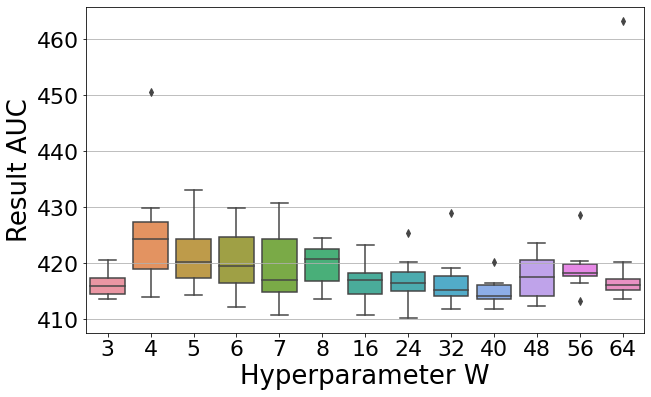

In [47]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=final_res_w.iloc[:, 2:])
plt.xticks(fontsize=22);
plt.yticks(fontsize=22);
plt.xlabel('Hyperparameter W', fontsize=26)
plt.ylabel('Result AUC', fontsize=26);
plt.grid(axis='y')
#plt.savefig('compare_ws.pdf', bbox_inches='tight')